# Peter O'Mahony
# ID: 8361967
# E-tivity 3 - Classification

_Open a new Jupyter notebook and name it etivity3_classification.ipynb. In this notebook, first of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. Then train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator, respectively, to train a model that predicts the value of `insurance_cost_binary`._

_Requirements:_

* _For each classifier, include data preparation and dimensionality reduction steps in the main pipeline._
* _You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them._
* _For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique._
* _Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one._
* _Summarise your experience in a markdown cell (max 150 words in a markdown cell)._

In [215]:
import pandas as pd # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer #needed for data preparation
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

%matplotlib inline

# set display settings so that we use full width of my screen
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
pd.options.display.width = 2000
pd.options.display.float_format = "{:,.2f}".format


Load the dataset and do some analysis.  Note that this etivity is about Pipelines and Dimensionality Reduction so I'm not going to go into detail on the Analysis and Pre-processing steps.

In [216]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender   bmi  children smoker     region  insurance_cost
0   18    male 33.77         1     no  southeast        1,725.55
1   18    male 34.10         0     no  southeast        1,137.01
2   18  female 26.32         0     no  northeast        2,198.19
3   18  female 38.66         2     no  northeast        3,393.36
4   18  female 35.62         0     no  northeast        2,211.13

In [217]:
df.describe()

age      bmi  children  insurance_cost
count 1,338.00 1,338.00  1,338.00        1,338.00
mean     39.21    30.66      1.09       13,270.42
std      14.05     6.10      1.21       12,110.01
min      18.00    15.96      0.00        1,121.87
25%      27.00    26.30      0.00        4,740.29
50%      39.00    30.40      1.00        9,382.03
75%      51.00    34.69      2.00       16,639.91
max      64.00    53.13      5.00       63,770.43

Replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise

In [218]:

icm = df.insurance_cost.median()
print('median',icm)
df['insurance_cost_binary'] = [0 if x <= icm else 1 for x in df.insurance_cost]

median 9382.033


For each Classifier include:
1. Data Preparation
2. Dimensionality Reduction


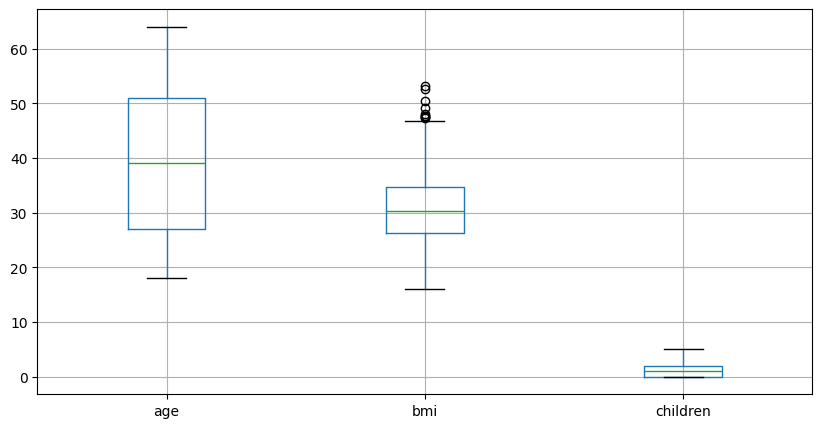

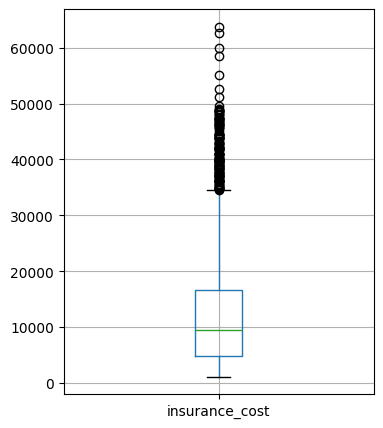

In [219]:
# Analyse the numeric features
# show these three on one plot because they have a similar scale
df.loc[:,'age':'children'].boxplot(figsize=(10,5))
plt.show()

# different scale
df.loc[:,'insurance_cost':'insurance_cost'].boxplot(figsize=(4,5))
plt.show()


It appears that we have lots of outliers in bmi and insurance_cost and it's worth doing further analysis on insurance_cost to find influencers.

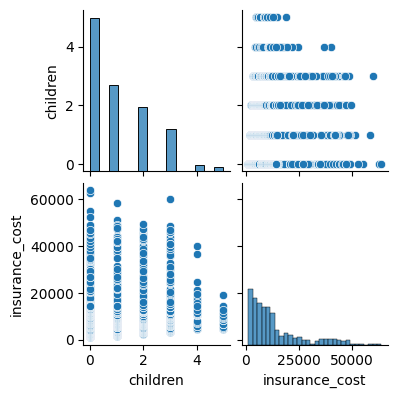

In [220]:
#sns.pairplot(data=df[['smoker','children','insurance_cost']].dropna(), height=2)
#plt.show()

sns.pairplot(data=df[['children','insurance_cost']].dropna(), height=2)
plt.show()



          count      mean       std       min       25%       50%       75%       max
smoker                                                                               
no     1,064.00  8,434.27  5,993.78  1,121.87  3,986.44  7,345.41 11,362.89 36,910.61
yes      274.00 32,050.23 11,541.55 12,829.46 20,826.24 34,456.35 41,019.21 63,770.43


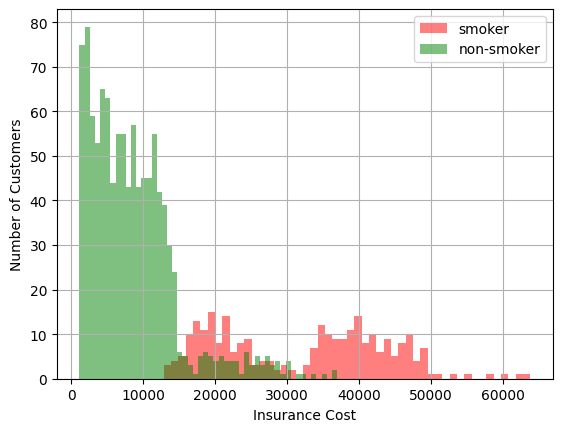

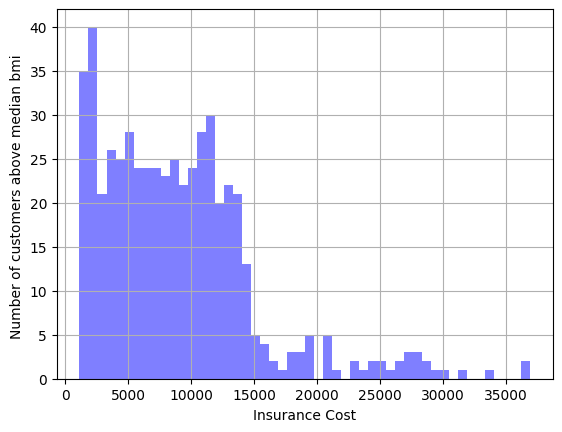

In [221]:
print(df.groupby('smoker')['insurance_cost'].describe())

df['insurance_cost'][(df['smoker'] == 'yes')].hist(bins=50, label='smoker', color='r', alpha=0.5)
df['insurance_cost'][(df['smoker'] == 'no')].hist(bins=50, label='non-smoker', color='g', alpha=0.5)
plt.xlabel('Insurance Cost')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

# smoking has a big impact on the insurance cost so let's just focus on non-smokers to see what we can learn about above BMI median influence
df['insurance_cost'][((df['bmi'] > df['bmi'].median()) & (df['smoker'] == 'no')) ].hist(bins=50, label='non-smoker', color='b', alpha=0.5)
plt.xlabel('Insurance Cost')
plt.ylabel('Number of customers above median BMI')
plt.show()

Total rows with outliers:       148.0
Total rows with missing values: 0.0
Description
              age      bmi  children  insurance_cost  insurance_cost_binary  gender  smoker  region
count   1,338.00 1,338.00  1,338.00        1,338.00               1,338.00     NaN     NaN     NaN
mean       39.21    30.66      1.09       13,270.42                   0.50     NaN     NaN     NaN
std        14.05     6.10      1.21       12,110.01                   0.50     NaN     NaN     NaN
min        18.00    15.96      0.00        1,121.87                   0.00     NaN     NaN     NaN
25%        27.00    26.30      0.00        4,740.29                   0.00     NaN     NaN     NaN
50%        39.00    30.40      1.00        9,382.03                   0.50     NaN     NaN     NaN
75%        51.00    34.69      2.00       16,639.91                   1.00     NaN     NaN     NaN
max        64.00    53.13      5.00       63,770.43                   1.00     NaN     NaN     NaN
IQR        24.00     8

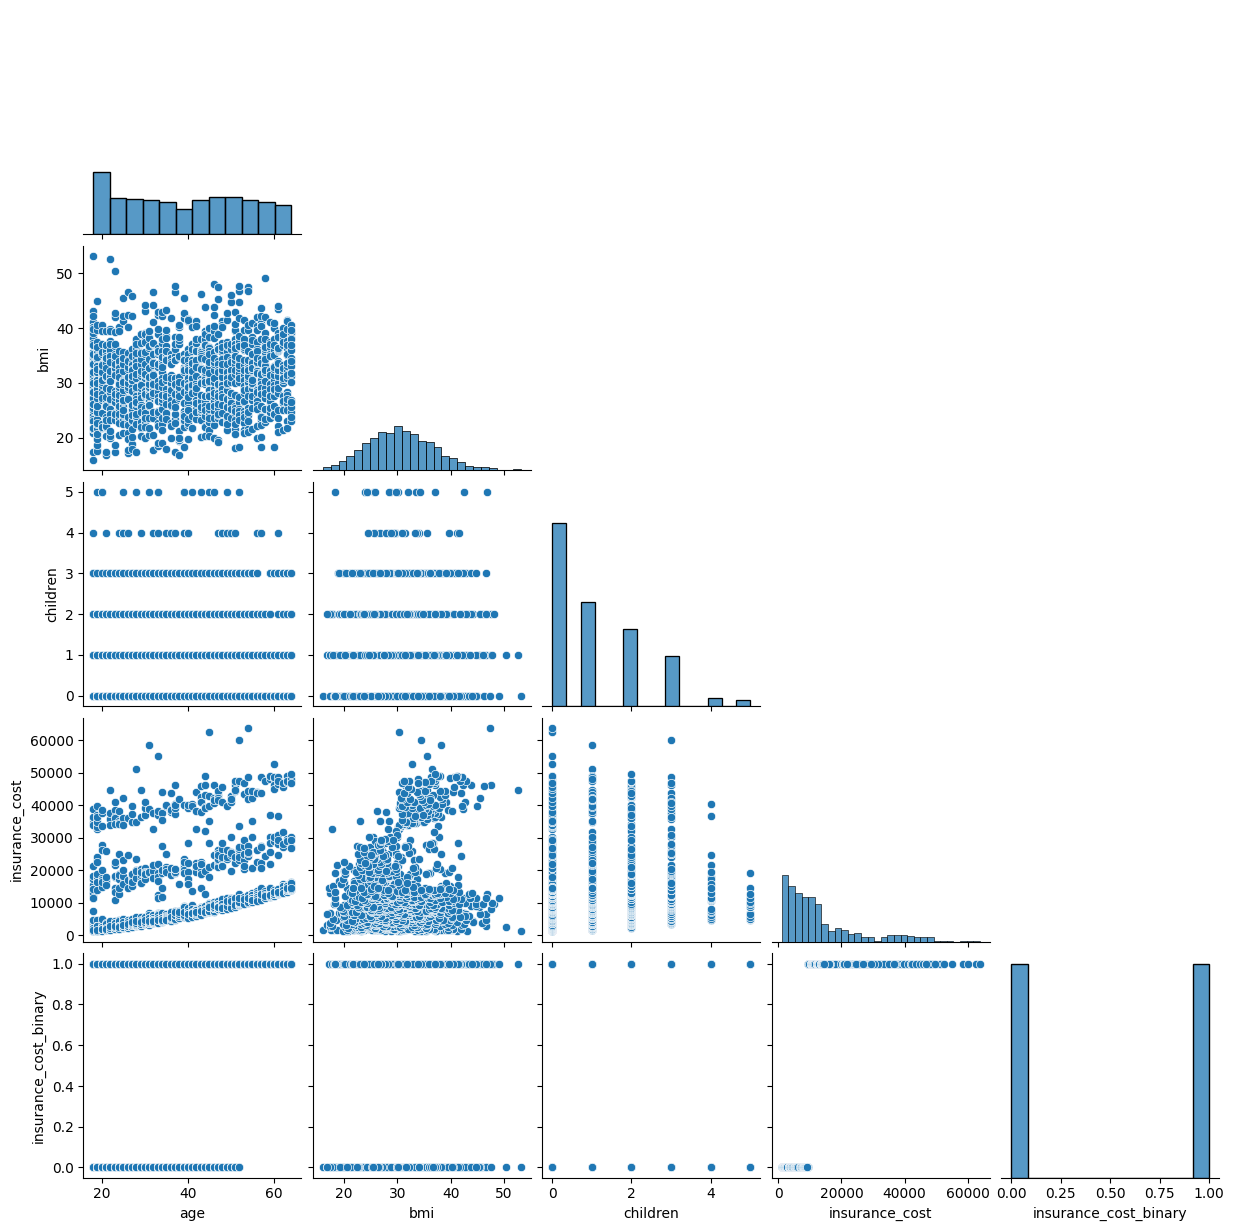

In [205]:
# create a list of analytics for each numeric feature
desc = df.describe()

for num_feature in desc:
    # calculate the inter quartile range
    desc.loc['IQR',   num_feature] = desc[num_feature]['75%'] - desc[num_feature]['25%']
    desc.loc['out_lo',num_feature] = desc[num_feature]['25%'] - desc[num_feature]['IQR'] * 1.5
    desc.loc['out_hi',num_feature] = desc[num_feature]['75%'] + desc[num_feature]['IQR'] * 1.5

    # identify the high and low boundaries for outliers
    out_lo = desc[num_feature]['25%'] - desc[num_feature]['IQR'] * 1.5
    out_hi = desc[num_feature]['75%'] + desc[num_feature]['IQR'] * 1.5

    # count the number of outliers
    out_cnt =( (df[num_feature] > out_hi) | (df[num_feature] < out_lo)).sum()
    desc.loc['out_cnt',num_feature] = out_cnt

    # count the number of missing values
    desc.loc['missing',num_feature] = df[num_feature].isna().sum()


# for all the categorical features, count the number of missing values
objects = df.select_dtypes(include=['object']).columns.tolist()
for num_feature in objects:
    desc.loc['missing',num_feature] = df[num_feature].isna().sum()

# show how many rows contained outliers
print(f'Total rows with outliers:      ',desc.loc['out_cnt'].sum())
print(f'Total rows with missing values:',desc.loc['missing'].sum())

# show the analytics
print('Description\n',desc)

sns.pairplot(df, corner=True)

OK this etivity isn't about analysis let's focus and build the pipeline based on this summary.

|Feature|Range|Outliers|Encoding|Scaling|Notes|
|---    |--:           |--:     |---     |---     |---|
|age|18-62|No|Banded|MinMax|16 bins
|gender|male, female|No|One-hot|No
|bmi|16-53|9|Discrete|MinMax|Band as follows:<br>Underweight: Less than 18.5<br>Optimum range: 18.5 to 24.9<br>Overweight: 25 to 29.9<br>Class I obesity: 30 to 34.9<br>Class II obesity: 35 to 39.9<br>Class III obesity: More than 40
|children|0-5|No|Ordinal|MinMax|Does this contribute to the number of people covered by the policy? We could add a new binary feature: has_children. Could we create a numeric feature cost_per_person which is insurance_cost/(children+1) and then drop children and insurance_cost? It could generate a new target variable but one that is more focussed.
|smoker|yes, no|No|One-hot|No
|region|northeast, northwest, southeast, southwest|No|One-hot|No
|insurance_cost|1122-36911|139|None|None|Target Variable|


In [206]:
y = df['insurance_cost_binary']
X = df.drop(['insurance_cost','insurance_cost_binary'], axis=1)

In [222]:
# I want to discretise bmi into the six medical ordinals
def bmi_band(bmi):
    '''
    Underweight: Less than 18.5
    Optimum range: 18.5 to 24.9
    Overweight: 25 to 29.9
    Class I obesity: 30 to 34.9
    Class II obesity: 35 to 39.9
    '''
    if (bmi<18.5):
        band = 0
    elif (bmi<25):
        band = 1
    elif (bmi<30):
        band = 2
    elif (bmi<35):
        band = 3
    else:
        band = 4
    return band

def bmi_mapper(bmi):
    return bmi.map(lambda bmi: bmi_band(bmi) )

bmi_handler = Pipeline(steps=[
        ("hand_bmi",  FunctionTransformer(bmi_mapper, feature_names_out='one-to-one')),
        ("bmi_scale", MinMaxScaler())
        ])

age_handler = Pipeline(steps=[
        ('num_band',   KBinsDiscretizer(n_bins=16, encode='ordinal', strategy='quantile')),
        ("mm_scaler",  MinMaxScaler())
        ])

preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", MinMaxScaler(),                         ['children']),
        ("band_age",  age_handler,                            ['age']),
        ("band_bmi",  bmi_handler,                            ['bmi']),
        ("oh_smoker", OneHotEncoder(handle_unknown="ignore"), ['smoker']),
        ("oh_gender", OneHotEncoder(handle_unknown="ignore"), ['gender']),
        ("oh_region", OneHotEncoder(handle_unknown="ignore"), ['region']),
    ],
    remainder="drop"
)

# First do a test run without GridSearch
selector = Pipeline(steps=[
        #('feature_sel_1', SelectFromModel(LinearSVC(dual="auto", penalty="l1",max_iter=12000))),
        ('feature_sel_1', RFE(estimator=LinearSVC(dual="auto", penalty="l1",max_iter=12000)) ),
        ])

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('feature_sel_1', selector),
    ('model', svm.SVC(probability=True, random_state=222))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# get our preprocessed data
df2 = preprocessor.fit_transform(X_train)
col_names = preprocessor.get_feature_names_out()
# Convert to dataframe
df_prepped = pd.DataFrame(df2, columns=col_names)
# Use this to verify that all (numeric) features have a maximum value of 1
print(df_prepped.describe())

# do the heavy lifting
my_svc = my_pipeline.fit(X_train, y_train)

# put our preprocessed data into our feature selector
df3 = selector.fit_transform(df2, y_train)
print('df2 shape:',df2.shape)
print('df3 shape:',df3.shape) # show that the number of features has been reduced
print('Feature reduction removed these features:',col_names[~selector['feature_sel_1'].get_support()])

set_config(display='diagram')
display(my_pipeline)

       numerical__children  band_age__age  band_bmi__bmi  oh_smoker__smoker_no  oh_smoker__smoker_yes  oh_gender__gender_female  oh_gender__gender_male  oh_region__region_northeast  oh_region__region_northwest  oh_region__region_southeast  oh_region__region_southwest
count             1,070.00       1,070.00       1,070.00              1,070.00               1,070.00                  1,070.00                1,070.00                     1,070.00                     1,070.00                     1,070.00                     1,070.00
mean                  0.22           0.51           0.65                  0.80                   0.20                      0.49                    0.51                         0.25                         0.23                         0.28                         0.24
std                   0.24           0.31           0.26                  0.40                   0.40                      0.50                    0.50                         0.43                

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', SVC(probability=True, random_state=222))])

The 'dry run' above has shown us that using LinearSVC results in the dropping of two features (gender_female and region_northwest).  

Repeating using RFE with LinearSVC results in the dropping of six features (children, gender_female, gender_male, region_northwest, region_southeast, region_southwest and region_northwest).

This may be useful information for simplifying our model by manually dropping those features (Feature Selection) during further development.

In [208]:
# Dimension Reduction
# I have selected LinearDiscriminantAnalysis as the third reduction algorithm
dimreds = [
    ('PCA', PCA(n_components=9)),  # keep 9 of the 11
    ('RFE', RFE(estimator=LinearSVC(dual="auto", penalty="l1",max_iter=12000)) ),
    ('LDA', LinearDiscriminantAnalysis() ),
    ]

In [209]:
# define our lists so that we can loop through n classifiers
best_params = {}
best_model = {}

param_grid_svm = {
    'C': [100, 150, 200, 250],         # Early testing suggest that I remove these options: 0.1, 1, 10, 
    'gamma': [0.01, 0.001, 0.0005],    # and these: 1, 0.1
    'kernel': ['rbf', 'linear']}       # and this: 'poly'

# comment out these fast parameters which were used during development to speed up graphing
#param_grid_svm = {'C': [200], 'gamma': [0.01], 'kernel': ['rbf']}

param_grid_rf = {
    'n_estimators' : [10,20,30,40],
    'max_depth': [2, 4, 6, 8, 10,15,25],
}

param_grid_mlp = {
    'activation' : ['tanh','relu'],
    'solver': ['adam','lbfgs'],
    'max_iter': [2500,5000,7500]
}

param_grid_nb = {}

param_grid_knn = {'n_neighbors':[3,4,5,6]}

param_grid_lr = {}


rs = 21
vb = 1

clfs = [
    ('SVM',          svm.SVC(probability=True, verbose=vb, random_state=rs), param_grid_svm ),
    ('RandomForest', RandomForestClassifier(verbose=vb, random_state=rs),    param_grid_rf  ),
    ('MLP',          MLPClassifier(verbose=vb, random_state=rs),             param_grid_mlp ),
    #('NaiveBayes',   GaussianNB(),                                           param_grid_nb ), # omitting this because it is not useful in this context
    ('kNN',          KNeighborsClassifier(),                                 param_grid_knn ),
    ('LogisticReg',  LogisticRegression(),                                   param_grid_lr ),
]

# for each model
for clf_name, clf, param_grid in clfs:
    print(clf_name, param_grid)

    # for each dimensionality reduction algorithm
    for dr_name, dr_model in dimreds:
        print('Apply Dimension Reduction using', dr_name)

        selector = Pipeline(steps=[
                ('feature_sel_1', dr_model),
                ])

        a_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('feature_sel_1', selector),
            ('model', clf),
        ])

        set_config(display='diagram')
        display(a_pipeline)

        search = GridSearchCV(
                    a_pipeline, 
                    {f'model__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},
                    n_jobs=-1,
                    cv=5,
                    refit=True
                    )
        
        my_data = search.fit(X_train, y_train)

        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters:      ",  search.best_params_)

        # store the best params and best model for later use
        best_params[f'{clf_name}/{dr_name}'] = search.best_params_
        best_model [f'{clf_name}/{dr_name}'] = search.best_estimator_

SVM {'C': [100, 150, 200, 250], 'gamma': [0.01, 0.001, 0.0005], 'kernel': ['rbf', 'linear']}
Apply Dimension Reduction using PCA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', SVC(probability=True, random_state=21, verbose=1))])

[LibSVM]Best CV score = 0.921:
Best parameters:       {'model__C': 200, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Apply Dimension Reduction using RFE


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', SVC(probability=True, random_state=21, verbose=1))])

[LibSVM]Best CV score = 0.915:
Best parameters:       {'model__C': 100, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Apply Dimension Reduction using LDA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  LinearDiscriminantAnalysis())])),
                ('model', SVC(probability=True, random_state=21, verbose=1))])

[LibSVM]Best CV score = 0.914:
Best parameters:       {'model__C': 250, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
RandomForest {'n_estimators': [10, 20, 30, 40], 'max_depth': [2, 4, 6, 8, 10, 15, 25]}
Apply Dimension Reduction using PCA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', RandomForestClassifier(random_state=21, verbose=1))])

Best CV score = 0.921:
Best parameters:       {'model__max_depth': 10, 'model__n_estimators': 30}
Apply Dimension Reduction using RFE


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', RandomForestClassifier(random_state=21, verbose=1))])

Best CV score = 0.923:
Best parameters:       {'model__max_depth': 4, 'model__n_estimators': 40}
Apply Dimension Reduction using LDA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  LinearDiscriminantAnalysis())])),
                ('model', RandomForestClassifier(random_state=21, verbose=1))])

Best CV score = 0.916:
Best parameters:       {'model__max_depth': 4, 'model__n_estimators': 10}
MLP {'activation': ['tanh', 'relu'], 'solver': ['adam', 'lbfgs'], 'max_iter': [2500, 5000, 7500]}
Apply Dimension Reduction using PCA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                  ('bmi_scale',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', MLPClassifier(random_state=21, verbose=1))])

Iteration 1, loss = 0.69973409
Iteration 2, loss = 0.68088998
Iteration 3, loss = 0.66349632
Iteration 4, loss = 0.64691645
Iteration 5, loss = 0.63098311
Iteration 6, loss = 0.61553735
Iteration 7, loss = 0.60073701
Iteration 8, loss = 0.58633993
Iteration 9, loss = 0.57184229
Iteration 10, loss = 0.55779179
Iteration 11, loss = 0.54420290
Iteration 12, loss = 0.53065718
Iteration 13, loss = 0.51717890
Iteration 14, loss = 0.50398607
Iteration 15, loss = 0.49143357
Iteration 16, loss = 0.47918520
Iteration 17, loss = 0.46700814
Iteration 18, loss = 0.45554408
Iteration 19, loss = 0.44417500
Iteration 20, loss = 0.43348607
Iteration 21, loss = 0.42319301
Iteration 22, loss = 0.41333466
Iteration 23, loss = 0.40353300
Iteration 24, loss = 0.39501684
Iteration 25, loss = 0.38632684
Iteration 26, loss = 0.37833485
Iteration 27, loss = 0.37079393
Iteration 28, loss = 0.36340969
Iteration 29, loss = 0.35664806
Iteration 30, loss = 0.35013736
Iteration 31, loss = 0.34418890
Iteration 32, los

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', MLPClassifier(random_state=21, verbose=1))])

Iteration 1, loss = 0.69979392
Iteration 2, loss = 0.67455670
Iteration 3, loss = 0.65312833
Iteration 4, loss = 0.63342374
Iteration 5, loss = 0.61498160
Iteration 6, loss = 0.59767955
Iteration 7, loss = 0.58153943
Iteration 8, loss = 0.56596083
Iteration 9, loss = 0.55062957
Iteration 10, loss = 0.53576973
Iteration 11, loss = 0.52140930
Iteration 12, loss = 0.50739539
Iteration 13, loss = 0.49378934
Iteration 14, loss = 0.48081120
Iteration 15, loss = 0.46829300
Iteration 16, loss = 0.45570295
Iteration 17, loss = 0.44350410
Iteration 18, loss = 0.43222980
Iteration 19, loss = 0.42090269
Iteration 20, loss = 0.41008078
Iteration 21, loss = 0.39999602
Iteration 22, loss = 0.39101053
Iteration 23, loss = 0.38262399
Iteration 24, loss = 0.37474896
Iteration 25, loss = 0.36782833
Iteration 26, loss = 0.36142820
Iteration 27, loss = 0.35495100
Iteration 28, loss = 0.34892359
Iteration 29, loss = 0.34336699
Iteration 30, loss = 0.33839531
Iteration 31, loss = 0.33401684
Iteration 32, los

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  LinearDiscriminantAnalysis())])),
                ('model', MLPClassifier(random_state=21, verbose=1))])

Iteration 1, loss = 0.72398579
Iteration 2, loss = 0.67624817
Iteration 3, loss = 0.63309293
Iteration 4, loss = 0.59419112
Iteration 5, loss = 0.55893175
Iteration 6, loss = 0.52769563
Iteration 7, loss = 0.49976257
Iteration 8, loss = 0.47423120
Iteration 9, loss = 0.45142389
Iteration 10, loss = 0.43125154
Iteration 11, loss = 0.41302639
Iteration 12, loss = 0.39677618
Iteration 13, loss = 0.38211378
Iteration 14, loss = 0.36891778
Iteration 15, loss = 0.35732482
Iteration 16, loss = 0.34643993
Iteration 17, loss = 0.33721801
Iteration 18, loss = 0.32878893
Iteration 19, loss = 0.32149864
Iteration 20, loss = 0.31487134
Iteration 21, loss = 0.30906158
Iteration 22, loss = 0.30398405
Iteration 23, loss = 0.29950428
Iteration 24, loss = 0.29546973
Iteration 25, loss = 0.29178432
Iteration 26, loss = 0.28867365
Iteration 27, loss = 0.28583807
Iteration 28, loss = 0.28333245
Iteration 29, loss = 0.28105566
Iteration 30, loss = 0.27906795
Iteration 31, loss = 0.27715841
Iteration 32, los

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...DE0>)),
                                                                  ('bmi_scale',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', KNeighborsClassifier())])

Best CV score = 0.896:
Best parameters:       {'model__n_neighbors': 3}
Apply Dimension Reduction using RFE


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', KNeighborsClassifier())])

Best CV score = 0.917:
Best parameters:       {'model__n_neighbors': 4}
Apply Dimension Reduction using LDA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                  ('bmi_scale',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  LinearDiscriminantAnalysis())])),
                ('model', KNeighborsClassifier())])

Best CV score = 0.909:
Best parameters:       {'model__n_neighbors': 5}
LogisticReg {}
Apply Dimension Reduction using PCA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...BADE0>)),
                                                                  ('bmi_scale',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', LogisticRegression())])

Best CV score = 0.908:
Best parameters:       {}
Apply Dimension Reduction using RFE


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearSVC(dual='auto',
                                                          max_iter=12000,
                                                          penalty='l1')))])),
                ('model', LogisticRegression())])

Best CV score = 0.909:
Best parameters:       {}
Apply Dimension Reduction using LDA


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16)),
                                                                  ('mm_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0...
                                                                  ('bmi_scale',
                                                                   MinMaxScaler())]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  LinearDiscriminantAnalysis())])),
                ('model', LogisticRegression())])

Best CV score = 0.902:
Best parameters:       {}


In [210]:
# This code was provided for the etivity

mean_fpr = np.linspace(start=0, stop=1, num=100)

# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

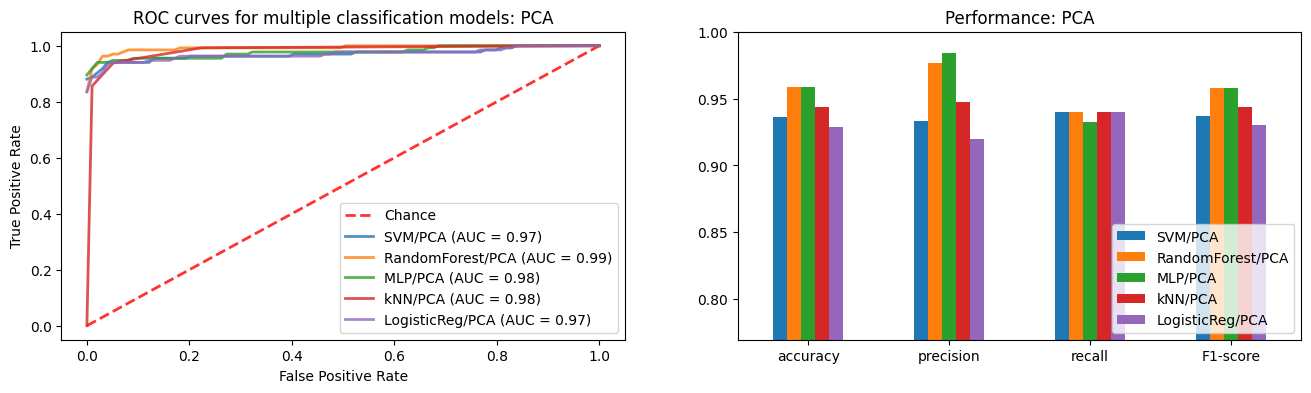

           SVM/PCA  RandomForest/PCA  MLP/PCA  kNN/PCA  LogisticReg/PCA
accuracy      0.94              0.96     0.96     0.94             0.93
precision     0.93              0.98     0.98     0.95             0.92
recall        0.94              0.94     0.93     0.94             0.94
F1-score      0.94              0.96     0.96     0.94             0.93
SUM OF METRICS (for coarse comparison!):
accuracy    4.73
precision   4.76
recall      4.69
F1-score    4.73
dtype: float64


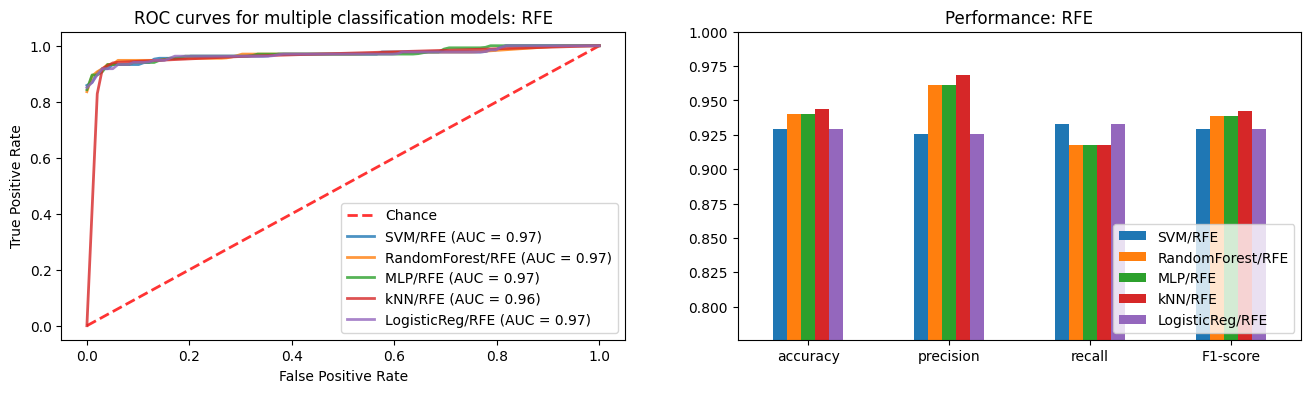

           SVM/RFE  RandomForest/RFE  MLP/RFE  kNN/RFE  LogisticReg/RFE
accuracy      0.93              0.94     0.94     0.94             0.93
precision     0.93              0.96     0.96     0.97             0.93
recall        0.93              0.92     0.92     0.92             0.93
F1-score      0.93              0.94     0.94     0.94             0.93
SUM OF METRICS (for coarse comparison!):
accuracy    4.68
precision   4.74
recall      4.62
F1-score    4.68
dtype: float64


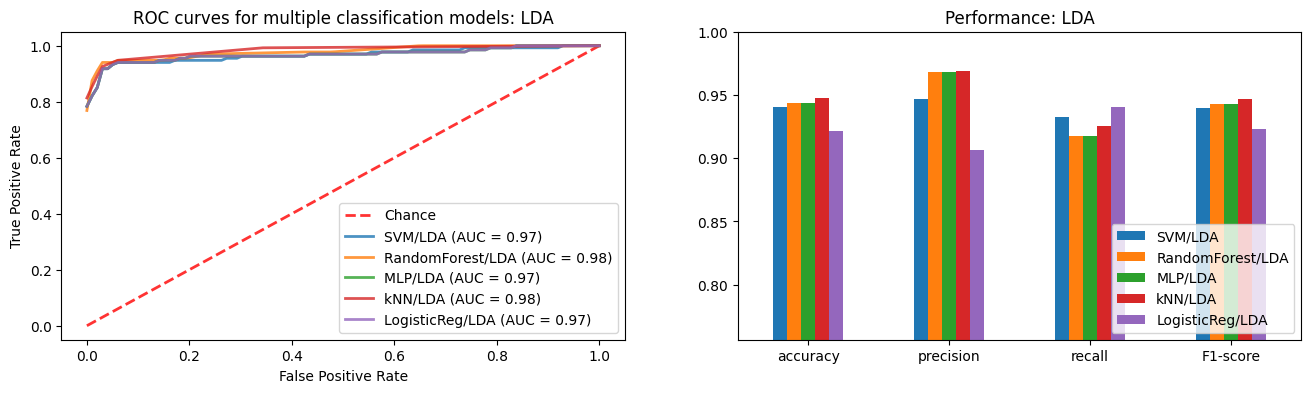

           SVM/LDA  RandomForest/LDA  MLP/LDA  kNN/LDA  LogisticReg/LDA
accuracy      0.94              0.94     0.94     0.95             0.92
precision     0.95              0.97     0.97     0.97             0.91
recall        0.93              0.92     0.92     0.93             0.94
F1-score      0.94              0.94     0.94     0.95             0.92
SUM OF METRICS (for coarse comparison!):
accuracy    4.70
precision   4.76
recall      4.63
F1-score    4.69
dtype: float64


In [226]:
# define list for analysis metrics
index = ['accuracy', 'precision', 'recall', 'F1-score']

for dr_name, dr in dimreds:
    df_metrics = pd.DataFrame()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

    for clf_name, clf, param_grid in clfs:
        # evaluate each model for each dimension reduction algorithm
        m_accuracy, m_precision, m_recall, m_f1_score, m_tpr, m_auc = evaluate_model(X_test, y_test, best_model[f'{clf_name}/{dr_name}'])

        # add metrics to frame for subsequent plotting on one chart
        df = pd.DataFrame({f'{clf_name}/{dr_name}': np.array([m_accuracy, m_precision, m_recall, m_f1_score])}, index=index)
        df_metrics = pd.concat([df_metrics, df], axis = 1)

        # plot ROC
        ax1.plot(mean_fpr, m_tpr[0,:], lw=2, label=f'{clf_name}/{dr_name} (AUC = %0.2f)' % (m_auc), alpha=0.8)

        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'ROC curves for multiple classification models: {dr_name}')
        ax1.legend(loc="lower right")

    df_metrics.plot.bar(rot=0, ax=ax2)
    ax2.set_title(f'Performance: {dr_name}')
    ax2.legend(loc="lower right")
    # adjust Y axis scale so that differences are more easily discernable
    ax2.set_ylim([np.min(df)-0.15,1])
    plt.show()

    print(df_metrics)
    print('SUM OF METRICS (for coarse comparison!):')
    print(df_metrics.sum(axis=1))


# Conclusion

I chose to build a loop structure for testing the algorithms and this facilitated my comparson with six classifiers.  I found the results of the NaiveBayes (GaussianNB) to be negatively distorting to my overall figures so I omitted it from the code above but it can be easily added in by uncommenting it within the clfs list structure.

Random Forest performs better than SVM on this dataset.

kNN performs better than Random Forest except when we use PCA for dimensional reduction.

This shows the benefits of experimentation when doing initial work with a new dataset.  It is useful to try combinations of classifiers and dimensional reduction techniques along with GridSearch or BayesSearch to vary the hyperparameters.  It helped speed up development by first noting the best performing hyperparameters and using them as the only parameters to GridSearch during development and then reverting to using the full range of hyperparameters for the analysis phase of the etivity.

It was very interesting to be able to see what parameters were actually removed by the Dimensional Reduction (DR) techniques and I think it would be useful to do this for every DR algorithm where possible.  An exercise that applies a list of DR algorithms and outputs the features that they choose to discard could give a deeper understanding of the dataset and the significance of its features.

At its most harsh, children, gender and region were removed. It seems clear that smoker is strongly influential in determining the cost of life insurance and it looks like BMI and age are the only other features with significant influence.